## DATASET MAPPING

In [2]:
import pandas as pd

# Load the census dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
census_df = pd.read_csv(url, names=column_names, na_values=' ?')

In [3]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
census_df['marital-status'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [5]:
# Mapping married and unmarried statuses
marital_mapping = {
    ' Never-married': 'Unmarried',
    ' Married-civ-spouse': 'Married',
    ' Divorced': 'Married',  # Consider divorced as married
    ' Married-spouse-absent': 'Married',
    ' Separated': 'Married',
    ' Married-AF-spouse': 'Married',
    ' Widowed': 'Married'
}

# Map the values in the 'marital-status' column
census_df['marital-status'] = census_df['marital-status'].map(marital_mapping)

## Handling Missing Values - Mode Imputation

In [6]:
# Check for missing values in each column
missing_values = census_df.isnull().sum()

# Display columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
workclass         1836
occupation        1843
native-country     583
dtype: int64


In [7]:
# Mode imputation for categorical columns
categorical_columns = ['workclass', 'occupation', 'native-country']
for column in categorical_columns:
    mode_value = census_df[column].mode()[0]  # Calculate the mode
    census_df[column].fillna(mode_value, inplace=True)  # Fill missing values with mode

In [8]:
# Check for missing values in each column
missing_values = census_df.isnull().sum()
print(missing_values)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [9]:
census_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Unmarried,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## SQL DATABASE CONNECTION

In [10]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('census_data.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Create the table
create_table_query = """
CREATE TABLE census_df (
    Age INTEGER,
    Workclass TEXT,
    Final_Weight INTEGER,
    Education TEXT,
    Education_Num INTEGER,
    Marital_Status TEXT,
    Occupation TEXT,
    Relationship TEXT,
    Race TEXT,
    Sex TEXT,
    Capital_Gain INTEGER,
    Capital_Loss INTEGER,
    Hours_Per_Week INTEGER,
    Native_Country TEXT,
    Income TEXT
);
"""
cursor.execute(create_table_query)

# Iterate over the rows of the DataFrame and construct the query for each row
for index, row in census_df.iterrows():
    # Extract values from the current row
    values = tuple(row)

    # Construct the query with the values
    query = f"""INSERT INTO census_df (age, workclass, Final_Weight, education, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country, income)
                VALUES {values}"""

    # Execute the query
    cursor.execute(query)

# Commit the changes to the database
conn.commit()

In [63]:
query = """SELECT Final_weight FROM census_df limit 10""";
cursor.execute(query)
result = cursor.fetchall()
print(result)

[(77516,), (83311,), (215646,), (234721,), (338409,), (284582,), (160187,), (209642,), (45781,), (159449,)]


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def efficient_aggregate_sql(data, attributes_numeric, attributes_categorical):
    # Create a connection to an in-memory SQLite database
    conn = sqlite3.connect('census_data.db')
    # Create a cursor object
    cursor = conn.cursor()

    # Construct the SQL query for efficient aggregation
    numeric_aggregates = ', '.join([f'AVG({attributes_numeric[i]}) AS mean_{attributes_numeric[i]}, SUM({attributes_numeric[i]}) AS sum_{attributes_numeric[i]}, COUNT({attributes_numeric[i]}) AS count_{attributes_numeric[i]}, MIN({attributes_numeric[i]}) AS min_{attributes_numeric[i]}, MAX({attributes_numeric[i]}) AS max_{attributes_numeric[i]}' for i in range(len(attributes_numeric))])
    categorical_attributes = ', '.join(attributes_categorical)
    query =  f"""
        SELECT
            {categorical_attributes},
            {numeric_aggregates}
        FROM census_df
        GROUP BY marital_status,sex;
    """


    # Execute the SQL query
    cursor.execute(query)
    # Fetch the results
    results = cursor.fetchall()
    # Convert results to DataFrame
    columns = attributes_categorical + [f'{agg}_{attributes_numeric[i]}' for i in range(len(attributes_numeric)) for agg in ['mean', 'sum', 'count', 'min', 'max']]
    aggregated_data = pd.DataFrame(results, columns=columns)

    query_married = f"""
        SELECT
            {categorical_attributes},
            {numeric_aggregates}
        FROM census_df
        where Marital_Status = 'Married'
        GROUP BY marital_status,sex;
    """

    query_unmarried = f"""
        SELECT
            {categorical_attributes},
            {numeric_aggregates}
        FROM census_df
        where Marital_Status = 'Unmarried'
        GROUP BY Marital_Status,sex;
    """
    # Execute the SQL query
    cursor.execute(query_married)
    # Fetch the results
    results_married = cursor.fetchall()
    # Convert results to DataFrame
    columns = attributes_categorical + [f'{agg}_{attributes_numeric[i]}' for i in range(len(attributes_numeric)) for agg in ['mean', 'sum', 'count', 'min', 'max']]
    aggregated_data_married = pd.DataFrame(results_married, columns=columns)

    # Execute the SQL query
    cursor.execute(query_unmarried)
    # Fetch the results
    results_unmarried = cursor.fetchall()
    # Close the cursor and connection
    cursor.close()
    conn.close()
    # Convert results to DataFrame
    columns = attributes_categorical + [f'{agg}_{attributes_numeric[i]}' for i in range(len(attributes_numeric)) for agg in ['mean', 'sum', 'count', 'min', 'max']]
    aggregated_data_unmarried = pd.DataFrame(results_unmarried, columns=columns)

    return aggregated_data,aggregated_data_married,aggregated_data_unmarried

In [119]:
attributes_numeric     = ['age', 'Final_Weight', 'education_num','capital_gain', 'capital_loss', 'hours_per_week']
attributes_categorical = ['Income','WorkClass','Education','Marital_Status','Occupation','Relationship','Race','Native_country','Sex']
aggregated_data,aggregated_data_married,aggregated_data_unmarried = efficient_aggregate_sql(census_df, attributes_numeric,attributes_categorical)

print("type(aggregated_data_sql) : ",type(aggregated_data_married))

type(aggregated_data_sql) :  <class 'pandas.core.frame.DataFrame'>


In [91]:
aggregated_data_married

,Income,WorkClass,Education,Marital_Status,Occupation,Relationship,Race,Native_country,Sex,mean_age,...,mean_capital_loss,sum_capital_loss,count_capital_loss,min_capital_loss,max_capital_loss,mean_hours_per_week,sum_hours_per_week,count_hours_per_week,min_hours_per_week,max_hours_per_week
0,<=50K,Private,Bachelors,Married,Prof-specialty,Wife,Black,Cuba,Female,1.0,...,5.0,30020,6004,5,5,6.0,36024,6004,6,6
1,<=50K,Self-emp-not-inc,Bachelors,Married,Exec-managerial,Husband,White,United-States,Male,1.0,...,5.0,79370,15874,5,5,6.0,95244,15874,6,6


In [120]:
from scipy.stats import entropy

# Define utility function to calculate K-L Divergence
def calculate_kl_divergence(p, q):
    return entropy(p, q)

def get_kl_divergences(aggregated_data_married, aggregated_data_unmarried, attributes_numerical, attributes_categorical):
    kl_divergences = {}

    # Iterate over common columns between married and unmarried data
    common_columns = set(aggregated_data_married.columns) & set(aggregated_data_unmarried.columns)
    for column in common_columns:
        if column.startswith('sum_') or column.startswith('mean_') or column.startswith('max_') or column.startswith('min_') or column.startswith('count_'):
            #print(column, "Column2")
            # Normalize data into probability distribution
            total_count_married = aggregated_data_married[column].sum()
            total_count_unmarried = aggregated_data_unmarried[column].sum()
            #print(total_count_married,total_count_unmarried,column,"Test3")
            epsilon = 1e-9  # Small epsilon value to avoid division by zero
            probability_distribution_married = (aggregated_data_married[column] + epsilon) / (total_count_married + epsilon)
            probability_distribution_unmarried = (aggregated_data_unmarried[column] + epsilon) / (total_count_unmarried + epsilon)
            '''
            # Handling outliers
            lower_bound = probability_distribution_married.quantile(0.05)
            upper_bound = probability_distribution_married.quantile(0.95)
            probability_distribution_married = probability_distribution_married.clip(lower=lower_bound, upper=upper_bound, axis=0)

            lower_bound = probability_distribution_unmarried.quantile(0.05)
            upper_bound = probability_distribution_unmarried.quantile(0.95)
            probability_distribution_unmarried = probability_distribution_unmarried.clip(lower=lower_bound, upper=upper_bound, axis=0)
            '''
            #print("married_prob_dist:", probability_distribution_married)
            #print("unmarried_prob_dist:", probability_distribution_unmarried)

            kl_score = calculate_kl_divergence(probability_distribution_married, probability_distribution_unmarried)
            #print(kl_score,column,"Test")
            #print("kl_score: ", kl_score)
            if kl_score > 0.0000001:  # Apply pruning condition
                kl_divergences[column] = kl_score

    return kl_divergences


In [121]:
# Compute K-L Divergences for each aggregation

attributes_numerical     = ['age', 'FinalWeight', 'education_num','capital_gain', 'capital_loss', 'hours_per_week']
attributes_categorical = ['Income','WorkClass','Education','Occupation','Relationship','Race','Native_country','Sex']

kl_divergences = get_kl_divergences(aggregated_data_married,aggregated_data_unmarried,attributes_numerical,attributes_categorical)

print("kl_divergences:",kl_divergences)

kl_divergences: {'sum_Final_Weight': 0.055759090744645634, 'count_education_num': 0.06263837558089283, 'count_Final_Weight': 0.06263837558089283, 'count_capital_loss': 0.06263837558089283, 'mean_capital_gain': 0.03474121416318399, 'max_Final_Weight': 7.388642352944806e-05, 'sum_age': 0.06182590308505939, 'count_age': 0.06263837558089283, 'mean_age': 3.3707786717298953e-06, 'min_Final_Weight': 0.07328103920110804, 'mean_hours_per_week': 0.0004779464764484206, 'sum_capital_loss': 0.12949122044679812, 'sum_hours_per_week': 0.06969216576732715, 'sum_education_num': 0.0744195981799202, 'sum_capital_gain': 0.1418260286078191, 'count_hours_per_week': 0.06263837558089283, 'min_hours_per_week': 0.0588915177448584, 'count_capital_gain': 0.06263837558089283, 'mean_capital_loss': 0.0213279137215705, 'mean_education_num': 0.000602677425252298, 'max_capital_loss': 0.0004366436103291488, 'mean_Final_Weight': 0.0001818392798070001}


In [122]:
views = sorted(kl_divergences.items(), key=lambda x: x[1], reverse=True)
print(len(views))
views

22


[('sum_capital_gain', 0.1418260286078191),
 ('sum_capital_loss', 0.12949122044679812),
 ('sum_education_num', 0.0744195981799202),
 ('min_Final_Weight', 0.07328103920110804),
 ('sum_hours_per_week', 0.06969216576732715),
 ('count_education_num', 0.06263837558089283),
 ('count_Final_Weight', 0.06263837558089283),
 ('count_capital_loss', 0.06263837558089283),
 ('count_age', 0.06263837558089283),
 ('count_hours_per_week', 0.06263837558089283),
 ('count_capital_gain', 0.06263837558089283),
 ('sum_age', 0.06182590308505939),
 ('min_hours_per_week', 0.0588915177448584),
 ('sum_Final_Weight', 0.055759090744645634),
 ('mean_capital_gain', 0.03474121416318399),
 ('mean_capital_loss', 0.0213279137215705),
 ('mean_education_num', 0.000602677425252298),
 ('mean_hours_per_week', 0.0004779464764484206),
 ('max_capital_loss', 0.0004366436103291488),
 ('mean_Final_Weight', 0.0001818392798070001),
 ('max_Final_Weight', 7.388642352944806e-05),
 ('mean_age', 3.3707786717298953e-06)]

## Top 5 views

In [123]:
top_5_views = views[:5]

In [124]:
top_5_views

[('sum_capital_gain', 0.1418260286078191),
 ('sum_capital_loss', 0.12949122044679812),
 ('sum_education_num', 0.0744195981799202),
 ('min_Final_Weight', 0.07328103920110804),
 ('sum_hours_per_week', 0.06969216576732715)]

In [125]:
# Extracting attribute, measure, and KL divergence from the list of tuples
attributes_total = [view[0] for view in views]
kl_divergences_total = [view[1] for view in views]

# Create DataFrame
df_views = pd.DataFrame({
    'Attribute': attributes_total,
    'KL Divergence': kl_divergences_total
})

# Display the DataFrame
df_views

,Attribute,KL Divergence
0,sum_capital_gain,0.141826
1,sum_capital_loss,0.129491
2,sum_education_num,0.074420
3,min_Final_Weight,0.073281
4,sum_hours_per_week,0.069692
5,count_education_num,0.062638
6,count_Final_Weight,0.062638
7,count_capital_loss,0.062638
8,count_age,0.062638
9,count_hours_per_week,0.062638


In [126]:
# Extracting attribute, measure, and KL divergence from the list of tuples
attributes = [view[0] for view in top_5_views]
kl_divergences = [view[1] for view in top_5_views]

# Create DataFrame
df_top_views = pd.DataFrame({
    'Attribute': attributes,
    'KL Divergence': kl_divergences
})

# Display the DataFrame
df_top_views

,Attribute,KL Divergence
0,sum_capital_gain,0.141826
1,sum_capital_loss,0.129491
2,sum_education_num,0.074420
3,min_Final_Weight,0.073281
4,sum_hours_per_week,0.069692


## Plot

In [99]:
aggregated_data

,Income,WorkClass,Education,Marital_Status,Occupation,Relationship,Race,Native_country,Sex,mean_age,...,mean_capital_loss,sum_capital_loss,count_capital_loss,min_capital_loss,max_capital_loss,mean_hours_per_week,sum_hours_per_week,count_hours_per_week,min_hours_per_week,max_hours_per_week
0,<=50K,Private,Bachelors,Married,Prof-specialty,Wife,Black,Cuba,Female,1.0,...,5.0,30020,6004,5,5,6.0,36024,6004,6,6
1,<=50K,Self-emp-not-inc,Bachelors,Married,Exec-managerial,Husband,White,United-States,Male,1.0,...,5.0,79370,15874,5,5,6.0,95244,15874,6,6
2,>50K,Private,Masters,Unmarried,Prof-specialty,Not-in-family,White,United-States,Female,1.0,...,5.0,23835,4767,5,5,6.0,28602,4767,6,6
3,<=50K,State-gov,Bachelors,Unmarried,Adm-clerical,Not-in-family,White,United-States,Male,1.0,...,5.0,29580,5916,5,5,6.0,35496,5916,6,6


   sum_capital_gain Marital_Status      Sex
0           4557807        Married   Female
1          26508424        Married     Male
2           1564543      Unmarried   Female
3           2458550      Unmarried     Male
   sum_capital_loss Marital_Status      Sex
0            422037        Married   Female
1           1861456        Married     Male
2            237015      Unmarried   Female
3            322192      Unmarried     Male
   sum_education_num Marital_Status      Sex
0              59561        Married   Female
1             162247        Married     Male
2              48534      Unmarried   Female
3              57895      Unmarried     Male
   min_Final_Weight Marital_Status      Sex
0             19395        Married   Female
1             13769        Married     Male
2             12285      Unmarried   Female
3             18827      Unmarried     Male
   sum_hours_per_week Marital_Status      Sex
0              225281        Married   Female
1              696773  

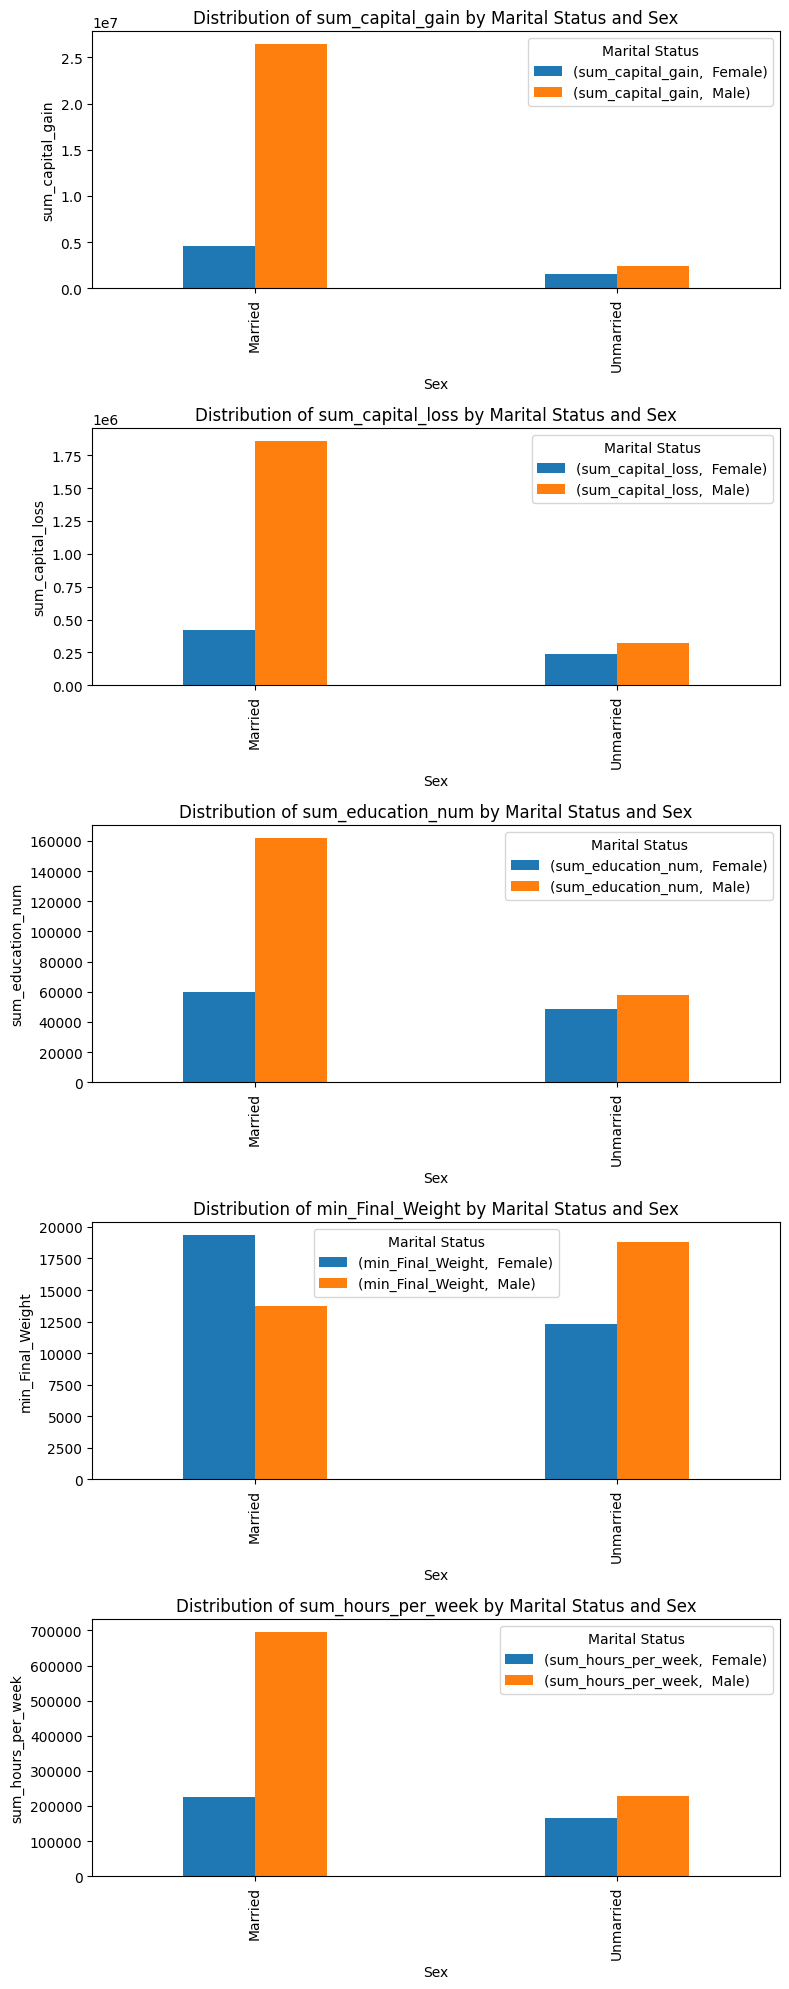

In [131]:
import matplotlib.pyplot as plt

# Extracting attribute names from top_5_views
attributes = [view[0] for view in top_5_views]

# Create subplots
fig, axes = plt.subplots(nrows=len(attributes), ncols=1, figsize=(8, len(attributes) * 4))

# Iterate through each attribute
for idx, attribute in enumerate(attributes):
    ax = axes[idx]


    # Filter data for the current attribute
    attribute_data = aggregated_data[[attribute, 'Marital_Status', 'Sex']]
    print(attribute_data)

    # Group data by Marital_Status and Sex and aggregate counts
    grouped_data = attribute_data.groupby(['Marital_Status', 'Sex']).sum().unstack(level=1)

    # Plot bars for married and unmarried individuals
    grouped_data.plot(kind='bar', ax=ax, stacked=False, width=0.4)  # Set width for each bar

    # Set plot title
    ax.set_title(f'Distribution of {attribute} by Marital Status and Sex')

    # Set x and y labels
    ax.set_xlabel('Sex')
    ax.set_ylabel(attribute)

    # Set legend
    ax.legend(title='Marital Status')

    # Set x-axis ticks and labels
    ax.set_xticks(range(len(grouped_data.index)))
    ax.set_xticklabels(grouped_data.index)
#plt.ticklabel_format(style = 'plain')

# Adjust layout
plt.tight_layout()
plt.show()